**ResNet**


---



Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


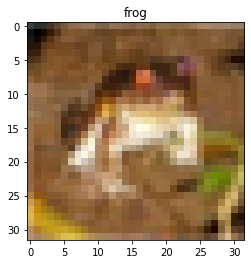

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
num_epochs = 100
batch_size = 128
learning_rate = 0.01

# transformations - they will be applied during dataloading
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


# Download dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./cifar10_data/',
    train=True,
    transform=train_transform,
    download=True)

test_dataset = torchvision.datasets.CIFAR10(
    root='./cifar10_data/',
    train=False,
    transform=test_transform,
    download=True)


# class names 
classes = train_dataset.classes


# class names
#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Dataset size
print(train_dataset.data.shape)
print(test_dataset.data.shape)

# print a sample image from dataset
image = train_dataset.data[0] #numpy array (32,32,3)
label = train_dataset.targets[0]

plt.imshow(image)
plt.title(classes[label])

# data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


ResNet consists of residual blocks. Each residual block has convolutional layers plus a short cut.

In [ ]:
# Define a 3x3 convolution function
def conv3x3(in_channels, out_channels, stride=1):
  return torch.nn.Conv2d(in_channels,
                         out_channels,
                         kernel_size=3,
                         stride=stride,
                         padding=1,
                         bias=False)

# Residual block
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super().__init__()
    self.conv1 = conv3x3(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
      
  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample:
        residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out


In [ ]:
# ResNet
class ResNet(nn.Module):

  # A residual block is repeated multiple times at each layer. When initialized,
  #   res_block is the residual block
  #   layers is a list of repetitions at each layer
  def __init__(self, res_block, layers, num_classes=10):
    super().__init__()
    # There is a layer of conv3x3, batchnorm, relu applied to the input image
    #   This is that layer. The number of out_channels is 16. 
    #   16 will then be in_channels for the residual layers
    self.in_channels = 16
    self.conv = conv3x3(3, 16)
    self.bn = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(inplace=True)
   
    # Now, we create the layers
    #   Each layer is made a function make_layer
    #   make_layer takes res_block, out_channel, repetitions and stride as input
    #   There are three layers 
    self.layer1 = self.make_layer(res_block, 16, layers[0], 1)
    self.layer2 = self.make_layer(res_block, 32, layers[1], 2)
    self.layer3 = self.make_layer(res_block, 64, layers[2], 2)

    # There is also average poling and a fully connected layer at the end
    self.avg_pool = nn.AvgPool2d(8)
    self.fc = nn.Linear(64, num_classes)

  # Function to build a layer
  def make_layer(self, res_block, out_channels, repetitions, stride=1):
    downsample = None
    # If to downsample, do it with conv2d and batchnorm
    if (stride != 1) or (self.in_channels != out_channels):
        downsample = nn.Sequential(
            conv3x3(self.in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(out_channels))
    
    # Each layer will be repeated applications of residual block
    # Create a list of layers and then unpack it 
    layers = []
    layers.append(res_block(self.in_channels, out_channels, stride, downsample))
    # if repetitions is greater then 1, append those
    for i in range(1, repetitions):
        layers.append(res_block(out_channels, out_channels))
    
    # in_channels attribute is update after making a layer, to be used for ... 
    #   the next layer
    self.in_channels = out_channels

    # unpack the list of layers and apply them sequentially 
    return nn.Sequential(*layers)

  # Now, the forward process
  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0), -1) # out.size(0) is the batch size
                                    # so, we flatten the rest of the tensor
    out = self.fc(out)
    return out

In [ ]:
# Create a model instantance
#   layers=[2,2,2] -> 3 layers, each with 2 residual blocks
model = ResNet(ResidualBlock, [2,2,2], num_classes=10).to(device)
print(model)
# Note that this prints the layers defined in the constructor __init__
#   layer1, layer2 and layer3 are created by the make_layer

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
# torchinfo displays a nicer summary with output shapes
!pip install torchinfo
from torchinfo import summary
summary(model, (1, 3, 32, 32), col_names=["kernel_size", "output_size", "num_params"])

In [ ]:
# Set the cost function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
# to change the learning rate during iterations
def update_lr(optimizer,lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [ ]:
# train the model
total_step = len(train_loader)
#print(total_step)
curr_lr = learning_rate
for epoch in range(num_epochs):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs,labels)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Display the loss at every 100 batch in an epoch
    if i % 100 == 0:
      print('epoch:',epoch,'batch:',i,'loss:',loss.item())
  
  # At every 20 epoch, reduce the learning to half
  if (epoch+1) % 20 == 0:
    curr_lr = curr_lr / 2
    update_lr(optimizer,curr_lr)


In [ ]:
# Test the model

# For loss calculation
total_loss = 0
total_correct = 0
dataset_size = len(test_loader.dataset)

# Put the model into evaluation mode
model.eval()

# Do not calculate gradients
with torch.no_grad():
  for X,y in test_loader:
    X = X.to(device)
    y = y.to(device)

    y_pred = model(X)

    # Calculate loss
    total_loss += criterion(y_pred, y).item()
    total_correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

print(f"Test Loss: {total_loss/dataset_size:0.4f}, \
        Test Accuracy: {total_correct/dataset_size:0.4f}")



Text(0.5, 1.0, 'True: deer, Predicted:deer')

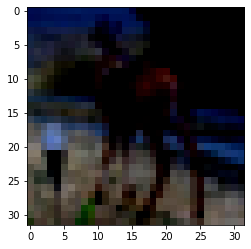

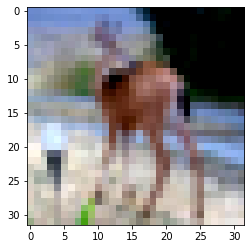

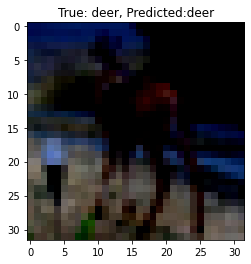

In [ ]:
# Test a single image
image, label = next(iter(test_loader))
#print(image.shape) # --> torch.Size([128, 3, 32, 32])

idx = 100
image0 = image[idx].to(device)
#print(image0.shape) # --> torch.Size([3, 32, 32])
#print(image0.unsqueeze(dim=0).shape) # --> torch.Size([1, 3, 32, 32])

label0 = label[idx].item()

y_pred = model(image0.unsqueeze(dim=0))
label_pred = y_pred.argmax(1).item()
# Note that images are normalized to [-0.5,0.5] range.
#   This will clip below 0; darks are clipped
plt.figure()
plt.imshow(image0.permute(1,2,0).cpu().numpy())
#   By adding 0.5, we brind the expected range to [0,1], and then clip
plt.figure()
plt.imshow(image0.permute(1,2,0).cpu().numpy()+0.5)
#   If would like to scale everything 
import matplotlib.colors as colors
plt.figure()
plt.imshow(image0.permute(1,2,0).cpu().numpy(),norm=colors.Normalize())

plt.title(f"True: {classes[label0]}, Predicted:{classes[label_pred]}")